# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [3]:
df.columns

Index(['article_id', 'title', 'email'], dtype='object')

In [4]:
print("The shape of the dataframe is: {}.".format(df.shape))
#dataframe df contains user item interaction, thus its length is the overall number of interactions
print("Thus, the number of user-item interactions is: {}.".format(df.shape[0]))
print("The  dataframe contains the following columns and datatypes:\n{}.".format(df.dtypes))
#We see that the user is decoded as a string which represents the email.
print("The number of recorded useres is: {}.".format(df['email'].nunique()))

#value_counts()
#print(df.describe())

The shape of the dataframe is: (45993, 3).
Thus, the number of user-item interactions is: 45993.
The  dataframe contains the following columns and datatypes:
article_id    float64
title          object
email          object
dtype: object.
The number of recorded useres is: 5148.


In [5]:
##Grouping by user and looking how often he appears with size
df.groupby('email').size().head()

email
0000b6387a0366322d7fbfc6434af145adf7fed1    13
001055fc0bb67f71e8fa17002342b256a30254cd     4
00148e4911c7e04eeff8def7bbbdaf1c59c2c621     3
001a852ecbd6cc12ab77a785efa137b2646505fe     6
001fc95b90da5c3cb12c501d201a915e4f093290     2
dtype: int64

In [6]:
# Fill in the median and maximum number of user_article interactions below

median_val = df.groupby('email').size().median()# 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = df.groupby('email').size().max()# The maximum number of user-article interactions by any 1 user is ______.
min_views_by_user = df.groupby('email').size().min()
av_views_by_user = df.groupby('email').size().mean()

print("50% of individuals interact with {} articles or fewer.".format(median_val))
print("The maximum number of user-article interactions by any 1 user is {}.".format(max_views_by_user))

50% of individuals interact with 3.0 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


In [7]:
#descriptive statistics of the user-item interaction summarized:
df.groupby('email').size().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
dtype: float64

In [8]:
#Article id and their respective number of interactions
df.groupby('article_id').size().head()

article_id
0.0    14
2.0    58
4.0    13
8.0    85
9.0    10
dtype: int64

In [9]:
#Article title and its respective number of interactions
df['title'].value_counts().head()

use deep learning for image classification                      937
insights from new york car accident reports                     927
visualize car data with brunel                                  671
use xgboost, scikit-learn & ibm watson machine learning apis    643
predicting churn with the spss random tree algorithm            627
Name: title, dtype: int64

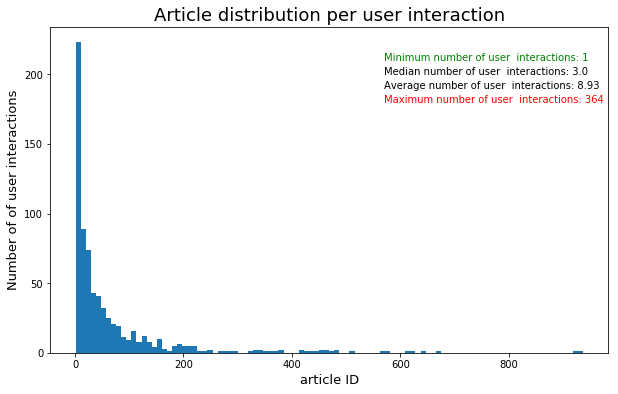

In [10]:
#Visual statistics to assist with giving a look at the number of times each user interacts with an article.
plt.figure(figsize=(10,6))
plt.title('Article distribution per user interaction',fontsize = 18)
plt.xlabel('article ID',fontsize = 13)
plt.ylabel('Number of of user interactions',fontsize = 13)

#plt.axvline(median_val, color='k', linestyle='dashed', linewidth=2)
#plt.axvline(max_views_by_user, color='g', linestyle='dashed', linewidth=2)
plt.text(570,210, 'Minimum number of user  interactions: {}'.format(min_views_by_user), color='g')
plt.text(570,200, 'Median number of user  interactions: {}'.format(median_val))
plt.text(570,190, 'Average number of user  interactions: {:.2f}'.format(av_views_by_user))
plt.text(570,180, 'Maximum number of user  interactions: {}'.format(max_views_by_user), color='r')

plt.hist(df.groupby('article_id').size(), bins=100);

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [11]:
# Find and explore duplicate articles

In [12]:
print("The shape of the dataframe is: {}.".format(df_content.shape))
print("The  dataframe contains the following columns and datatypes:\n{}.".format(df_content.dtypes))
print("The number of unique articles is: {}.".format(df_content['article_id'].nunique()))
#alternatively: df_content['article_id'].duplicated().sum()
print("The number of duplicate articles is: {}.".format(df_content.shape[0]-df_content['article_id'].nunique()))



The shape of the dataframe is: (1056, 5).
The  dataframe contains the following columns and datatypes:
doc_body           object
doc_description    object
doc_full_name      object
doc_status         object
article_id          int64
dtype: object.
The number of unique articles is: 1051.
The number of duplicate articles is: 5.


In [13]:
#The following articles are duplicates:
duplicate_articles = df_content[df_content['article_id'].duplicated()]
print(duplicate_articles['doc_full_name'])

365                         Graph-based machine learning
692    How smart catalogs can turn the big data flood...
761    Using Apache Spark as a parallel processing fr...
970                                Use the Primary Index
971    Self-service data preparation with IBM Data Re...
Name: doc_full_name, dtype: object


In [14]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset=['article_id'], keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [15]:
unique_articles = df['article_id'].nunique()# The number of unique articles that have at least one interaction
total_articles = df_content['article_id'].nunique()# The number of unique articles on the IBM platform
unique_users = df['email'].nunique()# The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

print("The number of unique articles that have at least one interaction is: {}.".format(unique_articles))
print("The number of unique articles on the IBM platform is: {}.".format(total_articles))
print("The number of unique users is: {}.".format(unique_users))
print("The number of user-article interactions is: {}.".format(user_article_interactions))

The number of unique articles that have at least one interaction is: 714.
The number of unique articles on the IBM platform is: 1051.
The number of unique users is: 5148.
The number of user-article interactions is: 45993.


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [16]:
#Lets examine this first
df.groupby('article_id').size().sort_values(ascending=False).head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
dtype: int64

In [17]:
df.groupby('article_id').count().sort_values('title',ascending=False).head()

,title,email
article_id,,
1429.0,937,937
1330.0,927,927
1431.0,671,671
1427.0,643,643
1364.0,627,627


In [18]:
#We can use the index and values functionality to acess these elements
print(df.groupby('article_id').count().sort_values('title',ascending=False).index[0])
print(df.groupby('article_id').count().sort_values('title',ascending=False).values[0][0])

1429.0
937


In [19]:
# The most viewed article in the dataset as a string with one value following the decimal 
most_viewed_article_id =  str(df.groupby('article_id').count().sort_values('title',ascending=False).index[0])
# The most viewed article in the dataset was viewed how many times?
max_views = df.groupby('article_id').count().sort_values('title',ascending=False).values[0][0]
print(most_viewed_article_id, type(most_viewed_article_id))
print(max_views)

1429.0 <class 'str'>
937


In [20]:
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [21]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the <u>popularity of an article can really only be based on how often an article was interacted with.</u>

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [22]:
df['title'].value_counts().sort_values(ascending=False).head(5).index.tolist()

['use deep learning for image classification',
 'insights from new york car accident reports',
 'visualize car data with brunel',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'predicting churn with the spss random tree algorithm']

In [23]:
df['article_id'].value_counts().sort_values(ascending=False).head(5).index.tolist()

[1429.0, 1330.0, 1431.0, 1427.0, 1364.0]

In [24]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles= df['title'].value_counts().sort_values(ascending=False).head(n).index.tolist()
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles_ids = df['article_id'].value_counts().sort_values(ascending=False).head(n).index.tolist()
    
 
    return top_articles_ids # Return the top article ids

In [25]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


In [26]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [27]:
print(df.columns)
print(df.shape)

Index(['article_id', 'title', 'user_id'], dtype='object')
(45993, 3)


In [28]:
user_item = df[['user_id','article_id']]
print(user_item.head())

   user_id  article_id
0        1      1430.0
1        2      1314.0
2        3      1429.0
3        4      1338.0
4        5      1276.0


In [29]:
user_item = df.groupby('user_id')['article_id'].value_counts()
print(user_item.head())

user_id  article_id
1        310.0         2
         585.0         2
         668.0         2
         1052.0        2
         1170.0        2
Name: article_id, dtype: int64


In [30]:
user_item = df.groupby('user_id')['article_id'].value_counts().unstack()#.fillna(0)
print(user_item.head(2))

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
2              NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1              NaN     NaN   ...       NaN     NaN     1.0     NaN     1.0   
2              NaN     NaN   ...       NaN     NaN     NaN     NaN     NaN   

article_id  1440.0  1441.0  1442.0  1443.0  1444.0  
user_id                                             
1              NaN     NaN     NaN     NaN     NaN  
2              NaN     NaN     NaN     NaN     NaN  

[2 rows x 714 columns]


In [31]:
user_item = df.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
print(user_item.head(2))

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1              0.0     0.0   ...       0.0     0.0     1.0     0.0     1.0   
2              0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   

article_id  1440.0  1441.0  1442.0  1443.0  1444.0  
user_id                                             
1              0.0     0.0     0.0     0.0     0.0  
2              0.0     0.0     0.0     0.0     0.0  

[2 rows x 714 columns]


In [32]:
user_item[user_item > 1] = 1
print(user_item.head(2))

article_id  0.0     2.0     4.0     8.0     9.0     12.0    14.0    15.0    \
user_id                                                                      
1              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

article_id  16.0    18.0     ...    1434.0  1435.0  1436.0  1437.0  1439.0  \
user_id                      ...                                             
1              0.0     0.0   ...       0.0     0.0     1.0     0.0     1.0   
2              0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   

article_id  1440.0  1441.0  1442.0  1443.0  1444.0  
user_id                                             
1              0.0     0.0     0.0     0.0     0.0  
2              0.0     0.0     0.0     0.0     0.0  

[2 rows x 714 columns]


In [33]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    #group dataframe['article_id'] by user id to shape the user into the row and article into column
    #value_count the interacted article_ids 
    #employ unstack() to format the missing cells with NaN, which are then filled with zero
    user_item = df.groupby('user_id')['article_id'].value_counts().unstack().fillna(0)
    #if user-article interaction generated from value_counts() is more than 1, set 1
    user_item[user_item > 1] = 1
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [34]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the <u>results for each user here are binary</u>, it (perhaps) makes sense to <u>compute similarity as the dot product</u> of two users. 

Use the tests to test your function.

In [35]:
dot_prod_users = user_item.dot(np.transpose(user_item))
print(dot_prod_users.head())

user_id  1     2     3     4     5     6     7     8     9     10    ...   \
user_id                                                              ...    
1        36.0   2.0   6.0   3.0   0.0   4.0   1.0   6.0   4.0   7.0  ...    
2         2.0   6.0   1.0   3.0   0.0   2.0   0.0   1.0   2.0   4.0  ...    
3         6.0   1.0  40.0   5.0   1.0   7.0   1.0   5.0   2.0   5.0  ...    
4         3.0   3.0   5.0  26.0   3.0   8.0   0.0   8.0   1.0   4.0  ...    
5         0.0   0.0   1.0   3.0   3.0   1.0   0.0   3.0   0.0   0.0  ...    

user_id  5140  5141  5142  5143  5144  5145  5146  5147  5148  5149  
user_id                                                              
1         7.0   0.0   0.0   4.0   0.0   1.0   0.0   0.0   0.0   0.0  
2         2.0   0.0   0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0  
3         7.0   0.0   0.0   5.0   0.0   2.0   0.0   0.0   0.0   0.0  
4         6.0   0.0   0.0   2.0   0.0   2.0   1.0   0.0   1.0   0.0  
5         0.0   0.0   0.0   0.0   0.0   

In [36]:
user_id = 1 # test example
dot_prod_users = np.dot(user_item[user_item.index == user_id],np.transpose(user_item))
print(dot_prod_users)

[[ 36.   2.   6. ...,   0.   0.   0.]]


In [37]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user -implemted by dot product with itself
    dot_prod_users = np.dot(user_item[user_item.index == user_id],np.transpose(user_item))
    similarity = pd.DataFrame(dot_prod_users, columns=user_item.index)

    # sort by similarity
    similarity = similarity.sort_values(0, axis=1, ascending = False) 

    # create list of just the ids
    idList = similarity.columns.tolist()
   
    # remove the own user's id
    most_similar_users = idList[1::]
       
    return most_similar_users # return a list of the users in order from most to least similar
        

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 5041]
The 5 most similar users to user 3933 are: [3933, 23, 3782, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [39]:
df[['article_id']].dtypes

article_id    float64
dtype: object

In [40]:
user_item.head(1)

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [41]:
user_item.index

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=5149)

In [42]:
np.where(user_item.index == 1)[0][0] #this just compares user_ids

0

In [43]:
article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()

In [44]:
print(article_ids)

[43.0, 109.0, 151.0, 268.0, 310.0, 329.0, 346.0, 390.0, 494.0, 525.0, 585.0, 626.0, 668.0, 732.0, 768.0, 910.0, 968.0, 981.0, 1052.0, 1170.0, 1183.0, 1185.0, 1232.0, 1293.0, 1305.0, 1363.0, 1368.0, 1391.0, 1400.0, 1406.0, 1427.0, 1429.0, 1430.0, 1431.0, 1436.0, 1439.0]


In [45]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    
    #generate dataframe for comparison with duplicate entries removed
    article_comparison = df.drop('user_id',axis=1).drop_duplicates()
    #compare if 'article_id' in article_comparison isin() the requested article_ids and return 'title'
    article_names = article_comparison[article_comparison['article_id'].isin(article_ids)]['title'].tolist()
    
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    #Takes the columns (article ids) from the user-item-matrix, then its subset that have an interaction of nonzero
    article_ids = user_item.columns[user_item.loc[user_id] == 1].tolist()
    #Converts the list of floats into a list of strings via list comprehension
    article_ids = [str(i) for i in article_ids]
    
    
    article_names = get_article_names(article_ids, df=df)
    
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on similiarity to the input user(_id)
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who have the same similiarity are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # find similar users to given user_id
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    # find article_id  given user interacted with / read
    interacted_article_id = get_user_articles(user_id, user_item=user_item)[0]
    
    # employ other/similar users and their article interaction to make recommendations to the given user
    recs = []
    userCount = 0 
    while len(recs) < m:
        #get id of another but similar user
        other_user_id = similar_users[userCount]
        #get interacted articles of the other user
        other_user_interacted_article_id = get_user_articles(other_user_id, user_item=user_item)[0]
        #set comparison in order to obtain unseen articles
        unseen_articles = list(set(other_user_interacted_article_id) - set(interacted_article_id))
        #add the unseen article to the user recommmendation (extend for multiple recs)
        recs.extend(set(unseen_articles))
        
        #go to the next similar user
        userCount +=1 
        
        #avoid infinite loop by break condition
        if userCount > len(similar_users):
            break
        else :
            pass
        
    #Random recommendation for a given user who...
    #1) initially has less than m recommended articles
    if len(recs) < m :
        recs.extend(df['article_id'].tolist())
        recs = recs[:m]

        
    #2) receives more than m recommendations    
    elif len(recs) > m:
        recs = recs[:m]
    
    #just to be sure
    elif len(recs) == m:
        recs = recs
    
    return recs # return your recommendations for this user_id    

In [46]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

['the unit commitment problem',
 'accelerate your workflow with dsx',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'data visualization playbook: telling the data story',
 'movie recommender system with spark machine learning',
 'machine learning exercises in python, part 1',
 'ml algorithm != learning machine',
 'using machine learning to predict parking difficulty',
 'airbnb data for analytics: mallorca reviews',
 'get started with streams designer by following this roadmap']

In [47]:
# own mini test function 3
user_id = 1
user_user_recs(user_id, m=10)

['1354.0',
 '26.0',
 '1101.0',
 '967.0',
 '720.0',
 '108.0',
 '1395.0',
 '339.0',
 '302.0',
 '812.0']

In [48]:
similar_users = find_similar_users(1, user_item=user_item)
userCount = 0 
similar_users[userCount]

3933

In [49]:
#mini test 1
article_ids = ['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0']
get_article_names(article_ids, df=df)

['healthcare python streaming application demo',
 'use xgboost, scikit-learn & ibm watson machine learning apis',
 'gosales transactions for naive bayes model',
 'use r dataframes & ibm watson natural language understanding',
 'build a python app on the streaming analytics service',
 'using deep learning to reconstruct high-resolution audio']

In [50]:
# own mini test 2
'''
user_id = 1
article_ids, article_names = get_user_articles(user_id, user_item=user_item)
print(article_ids)
print(article_names)
'''

'\nuser_id = 1\narticle_ids, article_names = get_user_articles(user_id, user_item=user_item)\nprint(article_ids)\nprint(article_names)\n'

In [51]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [52]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    # find similar users to given user_id
    similar_users = find_similar_users(user_id, user_item=user_item)
    #transform all entries into float
    similar_users = [float(i) for i in similar_users]
    
    # find article_id  given user interacted with / read
    num_interactions = df.groupby('user_id').count()['title'].values #still a numpy array
    num_interactions = pd.DataFrame(num_interactions)  #dataframe
    
    #calculate the dot product of the user_id section of the user_item with its transposed self ...
    dot_prod_users = np.dot(user_item[user_item.index == user_id],np.transpose(user_item))
    
    #...as bases for the calculation of the similiarity
    similarity = pd.DataFrame(dot_prod_users,columns=user_item.index).transpose()
    
    ##connect similarity meassurement and the corresponding article interaction of the neighbor user
    neighbors_df = pd.concat([similarity, num_interactions], axis=1, join='inner')
    neighbors_df.columns = ['similarity','num_interactions']
    
    #sort the neighbors_df by the similarity and then by number of interactions
    neighbors_df.sort_values(by=['similarity','num_interactions'],ascending=[False,False],inplace=True)

    #remove the given user_id
    neighbors_df = neighbors_df.iloc[1:]
     
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # find similar users to given user_id
    neighbors_df = get_top_sorted_users(user_id)
    
    # find article_id  given user interacted with / read
    interacted_article_id = get_user_articles(user_id, user_item=user_item)[0]
    
    recs = []
    userCount = 0 
    while len(recs) < m:
        #get id of another but similar user
        other_user_id = neighbors_df.iloc[userCount,0] #similar_users[userCount]
        #get interacted articles of the other user
        other_user_interacted_article_id = get_user_articles(other_user_id, user_item=user_item)[0]
        
        #sort interacted articles by number of interactions
        df_byInteraction = df[df['article_id'].isin(other_user_interacted_article_id)].groupby('article_id').count()
        df_byInteractionSorted = df_byInteraction.sort_values('title',ascending=False)['title']
        
        # iterate through interaction-sorted top articles to make recommendations
        top_article_id = []
        for i in range(0,df_byInteractionSorted.shape[0]):
            top_article_id.append(df_byInteractionSorted.index[i])   
            
            #set comparison in order to obtain unseen articles
            unseen_articles = list(set(top_article_id) - set(interacted_article_id))
            
            #set comparison in order to obtain not-yet recommended articles
            recommendThis =  list(set(top_article_id) - set(recs))
            
            #add the unseen article to the user recommmendation (extend for multiple recs)
            recs.extend(set(recommendThis))
        
        #go to the next similar user
        userCount +=1 
        
        #avoid infinite loop by break condition
        if userCount > neighbors_df.shape[0]:
            break
        else :
            pass
        
    #Random TOP recommendation for a given user who...
    #1) initially has less than m recommended articles
    if len(recs) < m :
        recs.extend(get_top_article_ids(m-len(recs)))
        recs = recs[:m]

        
    #2) receives more than m recommendations    
    elif len(recs) > m:
        recs = recs[:m]
    
    #just to be sure
    elif len(recs) == m:
        recs = recs
    
    #obtain article name for the recommendation
    rec_names = get_article_names(recs)
    
    return recs, rec_names

In [53]:
get_top_sorted_users(1, df=df, user_item=user_item).head(2)

,similarity,num_interactions
3933,35.0,3
3782,17.0,33


In [54]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
[1427.0, 1314.0, 1305.0, 1176.0, 1422.0, 1024.0, 1429.0, 1431.0, 1293.0, 1170.0]

The top 10 recommendations for user 20 are the following article names:
['healthcare python streaming application demo', 'use deep learning for image classification', 'apache spark lab, part 1: basic concepts', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'gosales transactions for naive bayes model', 'finding optimal locations of new store using decision optimization', 'use r dataframes & ibm watson natural language understanding', 'build a python app on the streaming analytics service', 'using deep learning to reconstruct high-resolution audio']


In [55]:
### Tests with a dictionary of results
user1_most_sim = get_top_sorted_users(1).index.values[0]
user131_10th_sim = get_top_sorted_users(131).index.values[9]

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [56]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


**Provide your response here.**

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [57]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 

# A new user might in general like the overall top 10 articles:
new_user_recs = get_top_article_ids(10, df=df)
#convert all ids from float to string as this is required for the assert
new_user_recs = [str(i) for i in new_user_recs]
print(new_user_recs)

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [58]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  Since there isn't one right answer for this recommendation tactic, no test functions are provided.  Feel free to change the function inputs if you decide you want to try a method that requires more input values.  The input values are currently set with one idea in mind that you may use to make content based recommendations.  One additional idea is that you might want to choose the most popular recommendations that meet your 'content criteria', but again, there is a lot of flexibility in how you might make these recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [59]:
def make_content_recs():
    '''
    INPUT:
    
    OUTPUT:
    
    '''

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

**Write an explanation of your content based recommendation system here.**

`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

In [60]:
# make recommendations for a brand new user


# make a recommendations for a user who only has interacted with article id '1427.0'



### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [61]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [62]:
# quick look at the matrix
user_item_matrix.head()

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [63]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices
s.shape, u.shape, vt.shape

((714,), (5149, 5149), (714, 714))

**As there are no missing values in the user_item matrix, we can directly perform SVD without wrangling the data beforehand.**

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

**Additional information: After the original user-item matrix is deconstructed with SVD, it is possible to estimate the orginal matrix again with the by SVD generated sub matrices. The higher the number of latent features (dimensions of the (s)igma diagonal matrix), the better but also more expensive is the estimation. An error can be calculated from differences between user matrix and its estimation.**

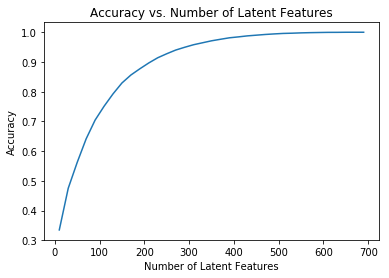

In [64]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [65]:
df_train = df.head(40000)
df_test = df.tail(5993)
df_test[['article_id']].head()
df_test.head()

,article_id,title,user_id
40000,1053.0,access mysql with python,4487
40001,1314.0,healthcare python streaming application demo,4487
40002,1424.0,use spark for python to load data and run sql ...,4487
40003,1176.0,build a python app on the streaming analytics ...,4487
40004,58.0,advancements in the spark community,4488


In [66]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    
    #Generate new user by item matrix from training and test data via function above
    user_item_train = create_user_item_matrix(df_train) 
    user_item_test = create_user_item_matrix(df_test)
    
    #obtain ids from the test users and articles
    test_idx = user_item_test.index.tolist()
    test_arts = user_item_test.columns.tolist()
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [67]:
#Analyze the text user item matrix - shows how exactly the items (article ids) and users (user ids) are implemented in the df
user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
#Number of user_ids (indices) 
print(user_item_test.index.shape[0])
#Number of article_ids (columns) 
print(user_item_test.columns.shape[0])

682
574


In [69]:
print("The number of user_id of the test dataframe is: {}.".format(user_item_test.shape[0]))
print("The number of user_id of the train dataframe is: {}.".format(user_item_train.shape[0]))
print("The number of mutual user_id of both dataframes is: {}.".format(len(np.intersect1d(user_item_test.index, user_item_train.index, assume_unique=True))))
print("The number of excluded user_id of test dataframes is: {}.".format(user_item_test.shape[0]-len(np.intersect1d(user_item_test.index, user_item_train.index, assume_unique=True))))

print("The number of mutual article_id of both dataframes is: {}.".format(len(np.intersect1d(user_item_test.columns, user_item_train.columns, assume_unique=True))))
print("The number of excluded article_id of test dataframes is: {}.".format(user_item_test.columns.shape[0]-len(np.intersect1d(user_item_test.columns, user_item_train.columns, assume_unique=True))))

The number of user_id of the test dataframe is: 682.
The number of user_id of the train dataframe is: 4487.
The number of mutual user_id of both dataframes is: 20.
The number of excluded user_id of test dataframes is: 662.
The number of mutual article_id of both dataframes is: 574.
The number of excluded article_id of test dataframes is: 0.


In [70]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 

#This should be items or articles, not movies - but else the test wont accept.
sol_4_dict = {
    'How many users can we make predictions for in the test set?': c, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, 
    'How many movies can we make predictions for in the test set?': b,
    'How many movies in the test set are we not able to make predictions for because of the cold start problem?': d
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [71]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)
s_train.shape, u_train.shape, vt_train.shape

((714,), (4487, 4487), (714, 714))

In [72]:
# The test data has to be carefully prepared, because only mutually included user can be predicted - look out for the proper dimensions!
u_test = u_train[user_item_train.index.isin(test_idx), :]
print("The number of actually predictable test user is: {}.".format(len(u_test)))
vt_test = vt_train[:, user_item_train.columns.isin(test_arts)]
print("The number of actually predictable test articles is: {}.".format(len(vt_test)))

The number of actually predictable test user is: 20.
The number of actually predictable test articles is: 714.


In [73]:
u_test.shape, vt_test.shape

((20, 4487), (714, 574))

In [74]:
# Generate true (predictable) test data on basis of mututual elements
user_item_true_test = user_item_test.loc[user_item_train.index.intersection(test_idx), user_item_train.columns.intersection(test_arts)]
print("The shape of true (actually predictable) test matrix is: {}.".format(user_item_true_test.shape))

The shape of true (actually predictable) test matrix is: (20, 574).


Thus, **only 20 users** appear in both training and test matrices. We can only use those for the reproducibility via the test data.

In [75]:
# Use these cells to see how well you can use the training - repeats procedure from above 2x; for both test and training data
num_latent_feats = np.arange(10,700+10,20)

sum_errs_train = []
sum_errs_test = []

for k in num_latent_feats:
    
    # restructure with k latent features
    s_new_train, u_new_train, vt_new_train = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    #new sigma matrix of train has to be employed for reconstruction
    u_new_test, vt_new_test = u_test[:, :k], vt_test[:k, :] 
    
    # take dot product
    user_item_est_train = np.around(np.dot(np.dot(u_new_train, s_new_train), vt_new_train))
    user_item_est_test = np.around(np.dot(np.dot(u_new_test, s_new_train), vt_new_test)) # s_new_train employed!
    
    # compute error for each prediction to actual value - employs the true test matrix
    diffs_train = np.subtract(user_item_train, user_item_est_train)
    diffs_test = np.subtract(user_item_true_test, user_item_est_test)
    
    # total errors and keep track of them
    err_train = np.sum(np.sum(np.abs(diffs_train)))
    err_test = np.sum(np.sum(np.abs(diffs_test)))
    sum_errs_test.append(err_test)
    sum_errs_train.append(err_train)
        
# decomposition to predict on test data    

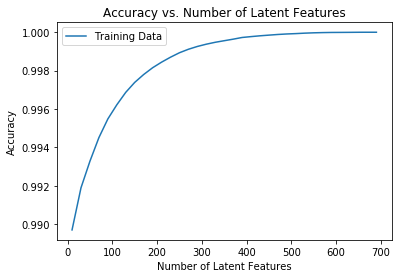

In [76]:
#Display of the accuracy for the training data

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(len(user_item_train.index)*len(user_item_test.columns)), label='Training Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

We can see that the accuracy of the test data initially rises expontentially and then slowly approaches a limit value at approximately 300 latent features. Thus, from the training data we can conclude at least 300 latent features are necessary.

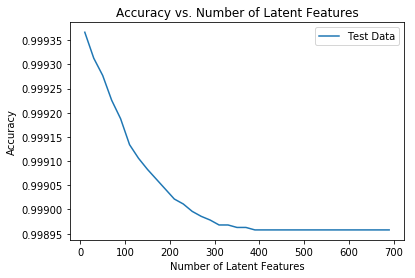

In [77]:
#Display of the accuracy for test data

plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(len(user_item_test.index)*len(user_item_test.columns)), label='Test Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

The accuracy of the test data interestingly shows an exponential decline with rising number of latent features, but the base line value has still a relatively high accuracy. It is possible that this is the result of the lower number of users which appear in both training and test data.

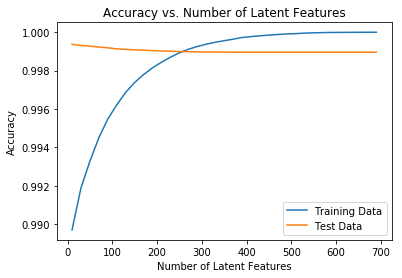

In [78]:
#Display of the accuracy for both training and test data

plt.plot(num_latent_feats, 1 - np.array(sum_errs_train)/(len(user_item_train.index)*len(user_item_test.columns)), label='Training Data');
plt.plot(num_latent_feats, 1 - np.array(sum_errs_test)/(len(user_item_test.index)*len(user_item_test.columns)), label='Test Data');
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');
plt.legend();

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Result discussion:**

The training data indicates that atleast 300 latent features are necessary to achieve a high accuracy. More latent features only increase the accuracy marginally. The test data declines with rising number of latent features to a relativly high baseline value. However, only 20 users appear in both training and test data. Thus, the data situation is insufficient for a recommender situation based on collaborative filtering methods like SVD. It is advisable to employ a larger data set with more mutual users.

**In conclussion**, for the established users either a rank-based approach should be employed or a combination of rank-based recommendations and collaborative filtering. Since the latter does not work for new users, here rank-based recommendations should be employed. 

**Further steps** should include testing the effect of <u>content based recommendations</u> (extra section). This might be done via an NLP modell. Wrapping the different parts of the recommender engine in classes would enhance the structure of the code. Finally, experiments on different user groups should be performed  with the old and the new recommender systems in comparison <u>(A/B-testing)</u> in order to validate the recommender engine.